In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded_files = files.upload()


Saving preprocess.csv to preprocess (2).csv


In [ ]:
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models  

import warnings# 移除不必要的警告
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from xgboost import plot_importance

In [ ]:
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/content/drive/MyDrive/chinese.simhei.ttf')#取得中文字型

sns.set(font=zhfont.get_name())

In [ ]:
df = pd.read_csv('preprocess.csv')

df.set_index(keys =df.columns[0],inplace=True)
df['y_class']=(df.y)>1


In [ ]:
df.index=pd.to_datetime(df.index,format="%Y/%m/%d")
df.index.name='date'
feature=df.columns[:-2]
print(len(feature))

feature_len=len(feature)

221


In [ ]:
DAYS_FOR_TRAIN=20
def deal_lstm(df,feature,n = DAYS_FOR_TRAIN):#以20天作為預測
    
    X = []
    y = []
    dataset_scaled_x = df[feature]
    
    for i in range(0, len(df)-n):
        X.append(dataset_scaled_x[i:i+n])
        y.append(df['y'].iloc[i+n-1])
    
    return (np.array(X),np.array(y))

In [ ]:
def tol_normalize(ddf):

  for col in feature:
    ddf[col]=MinMaxScaler().fit_transform(ddf[col].values.reshape(-1, 1))

  # ddf=MinMaxScaler().fit_transform(ddf)
  return ddf

[11:07:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


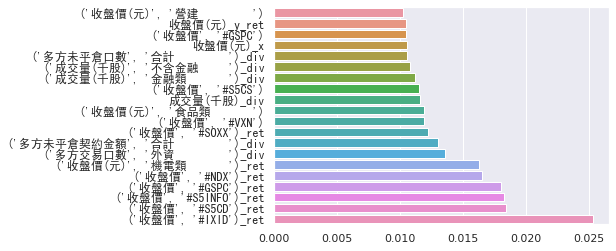

In [ ]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(df[:'2013'][feature], df[:'2013']['y'])
sorted_idx = xgb.feature_importances_.argsort()
# plot_importance(xgb, max_num_features = 20)#xgb內建畫圖，但比較不漂亮
sns.set(font=zhfont.get_name())
plt.yticks(fontproperties=zhfont)

sns.barplot(xgb.feature_importances_[sorted_idx][-20::],feature[sorted_idx][-20::] )

feature_new=feature[sorted_idx][-20::]

In [ ]:
train_x,train_y=deal_lstm(tol_normalize(df[:'2013']),feature_new)
valid_x,valid_y=deal_lstm((df['2013':'2017']),feature_new)
test_x,test_y=deal_lstm((df['2017':]),feature_new)

In [ ]:
print(train_x.shape)
print(train_y.shape)

(1594, 20, 20)
(1594,)


In [ ]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [ ]:
import tensorflow as tf

In [ ]:
class Attention_Layer():
    def __init__(
        self,
        timewindow_size,
        input_hidden_unit_size,
        attention_size=None):

        if(attention_size is None):
            attention_size=input_hidden_unit_size
        self.o_size = attention_size
        self.h_size = input_hidden_unit_size
        self.t_size = timewindow_size

        self.beta_weight = tf.Variable(tf.random.normal([self.h_size,self.o_size]), name='beta_weight')
        self.beta_bias = tf.Variable(tf.zeros([self.o_size]),name='beta_bias')

        self.v = tf.Variable(tf.random.normal([self.o_size,1]),name='beta_v')

    def __call__(self,inputs):
        #temp = tanh(Y X W + b) ->shape of result = (-1, self.o_size)
        temp=tf.matmul(tf.reshape(inputs.cpu().detach().numpy(),[-1,self.h_size]),self.beta_weight)
        #print(temp.shape)
        temp=tf.tanh(temp + self.beta_bias)
        #print(temp.shape)
            
        #j=temp X vv
        j=tf.reshape(tf.matmul(temp,self.v),[-1,self.t_size,1])

        #print(j.shape)

        beta=tf.nn.softmax(j)

        #print(beta.shape)
        #print(inputs.shape)

        output = beta*(inputs.cpu().detach().numpy())
        #print(output.shape)
        output = output.numpy()
        output = Variable(torch.from_numpy(output))
        return output

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=20, num_layers=1, output_dim=1):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)
        #print('a',out.shape)

        attention = Attention_Layer(20,20)

        out = attention(out)
        out = out.to(device)
        #print('b',out.shape)
        #print(type(out))

        # Index hidden state of last time step
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [ ]:
def MAPELoss(output,target):
  return torch.mean(torch.abs((target - output)/target))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#model = BiLSTM_Attention(input_dim=20).to(device)
model = LSTM(input_dim=20)
model = model.to(device)
model = model.float()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

LSTM(
  (lstm): LSTM(20, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
train = ElecDataset(train_x.reshape(train_x.shape[0],-1,train_x.shape[1]),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],-1,valid_x.shape[1]),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid,batch_size=128,shuffle=False)

In [ ]:
train_losses = []
valid_losses = []
train_accs = []
val_accs = []

def Train():
    
    running_loss = .0
    train_acc = 0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        inputs = inputs.float()
        labels = labels.to(device)
        labels = labels.float()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = MAPELoss(preds,labels)
        #loss = 
        loss.backward()
        optimizer.step()
        running_loss += loss
        mse = nn.MSELoss()
        acc = mse(preds,labels)
        train_acc = train_acc + acc.item()
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_acc = train_acc/len(train_loader)
    train_accs.append(train_acc)
    
    print(f'train_loss {train_loss}')
    print(f'train_acc {train_acc}')

In [ ]:
def Valid():
    running_loss = .0
    val_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            inputs = inputs.float()
            labels = labels.to(device)
            labels = labels.float()
            optimizer.zero_grad()
            preds = model(inputs)
            loss = MAPELoss(preds,labels)
            running_loss += loss
            mse = nn.MSELoss()
            acc = mse(preds,labels)
            val_acc = val_acc + acc.item()
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().cpu().numpy())
        val_acc = val_acc/len(valid_loader)
        val_accs.append(val_acc)

        print(f'valid_loss {valid_loss}')
        print(f'val_acc {val_acc}')

In [ ]:
epochs = 1000
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

串流輸出內容已截斷至最後 5000 行。
epochs 1/1000
train_loss 161.82998657226562
train_acc 0.05009651900484012
valid_loss 256.04241943359375
val_acc 0.14024005085229874
epochs 2/1000
train_loss 161.52783203125
train_acc 0.04991111847070547
valid_loss 255.85948181152344
val_acc 0.14007083252072333
epochs 3/1000
train_loss 161.22573852539062
train_acc 0.049726069833223634
valid_loss 255.67649841308594
val_acc 0.13990178108215331
epochs 4/1000
train_loss 160.9236297607422
train_acc 0.04954137452519857
valid_loss 255.49351501464844
val_acc 0.13973288014531135
epochs 5/1000
train_loss 160.6215362548828
train_acc 0.04935702853477918
valid_loss 255.31057739257812
val_acc 0.13956415206193923
epochs 6/1000
train_loss 160.3194122314453
train_acc 0.04917303300820864
valid_loss 255.12759399414062
val_acc 0.13939557746052741
epochs 7/1000
train_loss 160.01731872558594
train_acc 0.048989384793318234
valid_loss 254.94461059570312
val_acc 0.13922713845968246
epochs 8/1000
train_loss 159.71524047851562
train_acc 0.048

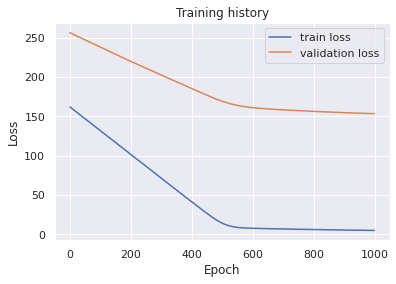

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0.000185, 0.0002]);

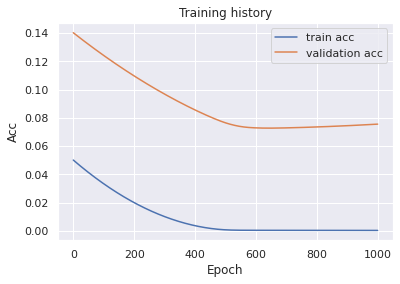

In [ ]:
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='validation acc')

plt.title('Training history')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0.000185, 0.0002]);